# Winery classification with the bivariate Gaussian

Our first generative model for Winery classification used just one feature. Now we use two features, modeling each class by a **bivariate Gaussian**.

## 1. Load in the data set

As in the univariate case, we start by loading in the Wine data set. Make sure the file `wine.data.txt` is in the same directory as this notebook.

Recall that there are 178 data points, each with 13 features and a label (1,2,3). As before, we will divide this into a training set of 130 points and a test set of 48 points.

In [1]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal 
# installing packages for interactive graphs
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

In [2]:
# Load data set.
data = np.loadtxt('wine.data.txt', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']
# Split 178 instances into training set (trainx, trainy) of size 130 and test set (testx, testy) of size 48
np.random.seed(0)
perm = np.random.permutation(178)
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

## 2. Look at the distribution of two features from one of the wineries

Our goal is to plot the distribution of two features from a particular winery. We will use several helper functions for this. It is worth understanding each of these.

The first helper function fits a Gaussian to a data set, restricting attention to specified features.
It returns the mean and covariance matrix of the Gaussian.

In [3]:
# Fit a Gaussian to a data set using the selected features
def fit_gaussian(x, features):
    mu = np.mean(x[:,features], axis=0)
    covar = np.cov(x[:,features], rowvar=0, bias=1)
    return mu, covar

For example, let's look at the Gaussian we get for winery 1, using features 0 ('alcohol') and 6 ('flavanoids').

In [4]:
f1 = 0
f2 = 6
label = 1
mu, covar = fit_gaussian(trainx[trainy==label,:], [f1,f2])
print "Mean:\n" + str(mu)
print "Covariance matrix:\n" + str(covar)

Mean:
[13.78534884  2.99627907]
Covariance matrix:
[[0.23325279 0.07526874]
 [0.07526874 0.15240941]]


Next, we will construct a routine for displaying points sampled from a two-dimensional Gaussian, as well as a few contour lines. Part of doing this involves deciding what range to use for each axis. We begin with a little helper function that takes as input an array of numbers (values along a single feature) and returns the range in which these numbers lie.

In [5]:
# Find the range within which an array of numbers lie, with a little buffer
def find_range(x):
    lower = min(x)
    upper = max(x)
    width = upper - lower
    lower = lower - 0.2 * width
    upper = upper + 0.2 * width
    return lower, upper

Next we define a routine that plots a few contour lines of a given two-dimensional Gaussian.
It takes as input:
* `mu`, `cov`: the parameters of the Gaussian
* `x1g`, `x2g`: the grid (along the two axes) at which the density is to be computed
* `col`: the color of the contour lines

In [18]:
def plot_contours(mu, cov, x1g, x2g, col):
    rv = multivariate_normal(mean=mu, cov=cov)
    z = np.zeros((len(x1g),len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            z[j,i] = rv.logpdf([x1g[i], x2g[j]]) 
    sign, logdet = np.linalg.slogdet(cov)
    normalizer = -0.5 * (2 * np.log(6.28) + sign * logdet)
    #for offset in range(1,4):
    plt.contour(x1g,x2g,z, levels=[normalizer-1], colors=col, linewidths=2.0, linestyles='solid')

The function **two_features_plot** takes an input two features and a label, and displays the distribution for the specified winery and pair of features.

The first line allows you to specify the parameters interactively using sliders.

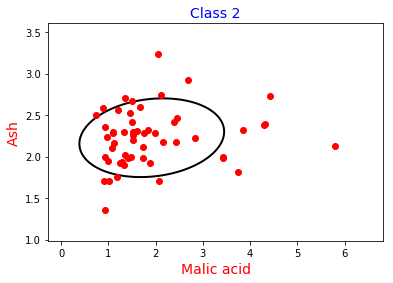

In [19]:
#@interact_manual( f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1), label=IntSlider(1,1,3,1) )
def two_features_plot(f1,f2,label):
    if f1 == f2: # we need f1 != f2
        print "Please choose different features for f1 and f2."
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[trainy==label,f1])
    x2_lower, x2_upper = find_range(trainx[trainy==label,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    plt.plot(trainx[trainy==label, f1], trainx[trainy==label, f2], 'ro')

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Now plot a few contour lines of the density
    mu, cov = fit_gaussian(trainx[trainy==label,:], [f1,f2])
    plot_contours(mu, cov, x1g, x2g, 'k')
    
    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Class ' + str(label), fontsize=14, color='blue')
    plt.show()

two_features_plot(1,2,2)

## 3. Fit a Gaussian to each class

We now define a function that will fit a Gaussian generative model to the three classes, restricted to a given list of features. The function returns:
* `mu`: the means of the Gaussians, one per row
* `covar`: covariance matrices of each of the Gaussians
* `pi`: list of three class weights summing to 1

In [20]:
# Assumes y takes on values 1,2,3
def fit_generative_model(x, y, features):
    k = 3 # number of classes
    d = len(features) # number of features
    mu = np.zeros((k+1,d)) # list of means
    covar = np.zeros((k+1,d,d)) # list of covariance matrices
    pi = np.zeros(k+1) # list of class weights
    for label in range(1,k+1):
        indices = (y==label)
        mu[label,:], covar[label,:,:] = fit_gaussian(x[indices,:], features)
        pi[label] = float(sum(indices))/float(len(y))
    return mu, covar, pi

Now we will plot the three Gaussians.

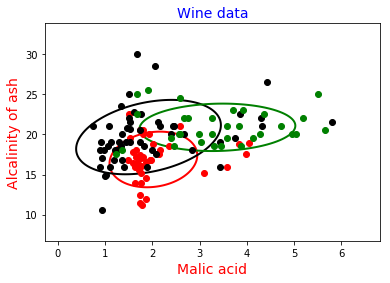

In [22]:
#@interact_manual( f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1) )
def three_class_plot(f1,f2):
    if f1 == f2: # we need f1 != f2
        print "Please choose different features for f1 and f2."
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Show the Gaussian fit to each class, using features f1,f2
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    for label in range(1,4):
        gmean = mu[label,:]
        gcov = covar[label,:,:]
        plot_contours(gmean, gcov, x1g, x2g, colors[label-1])

    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Wine data', fontsize=14, color='blue')
    plt.show()

three_class_plot(1,3)

## 4. Predict labels for the test points

How well we can predict the class (1,2,3) based just on these two features?

We start with a testing procedure that is analogous to what we developed in the 1-d case.

In [30]:
# Now test the performance of a predictor based on a subset of features
#@interact( f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1) )
def test_model(f1, f2):
    if f1 == f2: # need f1 != f2
        print "Please choose different features for f1 and f2."
        return  
    features= [f1,f2]
    mu, covar, pi = fit_generative_model(trainx, trainy, features)
    
    k = 3 # Labels 1,2,...,k
    nt = len(testy) # Number of test points
    score = np.zeros((nt,k+1))
    for i in range(0,nt):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            multivariate_normal.logpdf(testx[i,features], mean=mu[label,:], cov=covar[label,:,:])
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Finally, tally up score
    errors = np.sum(predictions != testy)
    print "Test error using feature(s): ",
    for f in features:
        print "'" + featurenames[f] + "'" + " ",
    print
    print "Errors: " + str(errors) + "/" + str(nt)# Now test the performance of a predictor based on a subset of features
    

for i in range(0,13):
    for k in range(0,13):
        if k != i:
            test_model(i,k)
            print(i)
            print(k)

Test error using feature(s):  'Alcohol'  'Malic acid' 
Errors: 9/48
0
1
Test error using feature(s):  'Alcohol'  'Ash' 
Errors: 12/48
0
2
Test error using feature(s):  'Alcohol'  'Alcalinity of ash' 
Errors: 9/48
0
3
Test error using feature(s):  'Alcohol'  'Magnesium' 
Errors: 14/48
0
4
Test error using feature(s):  'Alcohol'  'Total phenols' 
Errors: 5/48
0
5
Test error using feature(s):  'Alcohol'  'Flavanoids' 
Errors: 4/48
0
6
Test error using feature(s):  'Alcohol'  'Nonflavanoid phenols' 
Errors: 10/48
0
7
Test error using feature(s):  'Alcohol'  'Proanthocyanins' 
Errors: 8/48
0
8
Test error using feature(s):  'Alcohol'  'Color intensity' 
Errors: 8/48
0
9
Test error using feature(s):  'Alcohol'  'Hue' 
Errors: 6/48
0
10
Test error using feature(s):  'Alcohol'  'OD280/OD315 of diluted wines' 
Errors: 5/48
0
11
Test error using feature(s):  'Alcohol'  'Proline' 
Errors: 9/48
0
12
Test error using feature(s):  'Malic acid'  'Alcohol' 
Errors: 9/48
1
0
Test error using feature(s):

Test error using feature(s):  'Proanthocyanins'  'Hue' 
Errors: 11/48
8
10
Test error using feature(s):  'Proanthocyanins'  'OD280/OD315 of diluted wines' 
Errors: 16/48
8
11
Test error using feature(s):  'Proanthocyanins'  'Proline' 
Errors: 10/48
8
12
Test error using feature(s):  'Color intensity'  'Alcohol' 
Errors: 8/48
9
0
Test error using feature(s):  'Color intensity'  'Malic acid' 
Errors: 11/48
9
1
Test error using feature(s):  'Color intensity'  'Ash' 
Errors: 13/48
9
2
Test error using feature(s):  'Color intensity'  'Alcalinity of ash' 
Errors: 11/48
9
3
Test error using feature(s):  'Color intensity'  'Magnesium' 
Errors: 10/48
9
4
Test error using feature(s):  'Color intensity'  'Total phenols' 
Errors: 5/48
9
5
Test error using feature(s):  'Color intensity'  'Flavanoids' 
Errors: 3/48
9
6
Test error using feature(s):  'Color intensity'  'Nonflavanoid phenols' 
Errors: 12/48
9
7
Test error using feature(s):  'Color intensity'  'Proanthocyanins' 
Errors: 5/48
9
8
Test er

### <font color="magenta">Fast exercise 1</font>

Different pairs of features yield different test errors.
* What is the smallest achievable test error?
* Which pair of features achieves this minimum test error?

*Make a note of your answers to these questions, as you will need to enter them as part of this week's assignment.*

## 5. The decision boundary 

The function **show_decision_boundary** takes as input two features, builds a classifier based only on these two features, and shows a plot that contains both the training data and the decision boundary.

To compute the decision boundary, a dense grid is defined on the two-dimensional input space and the classifier is applied to every grid point. The built-in `pyplot.contour` function can then be invoked to depict the boundary.

In [31]:
def show_decision_boundary(f1,f2):
    # Fit Gaussian to each class
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    
    # Set up dimensions of plot
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim([x1_lower,x1_upper])
    plt.ylim([x2_lower,x2_upper])

    # Plot points in training set
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Define a dense grid; every point in the grid will be classified according to the generative model
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Declare random variables corresponding to each class density
    random_vars = {}
    for label in range(1,4):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])

    # Classify every point in the grid; these are stored in an array Z[]
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            scores = []
            for label in range(1,4):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1

    # Plot the contour lines
    plt.contour(x1g,x2g,Z.T,3,cmap='seismic')
    
    # Finally, show the image
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

Let's use the function above to draw the decision boundary using features 0 ('alcohol') and 6 ('flavanoids').

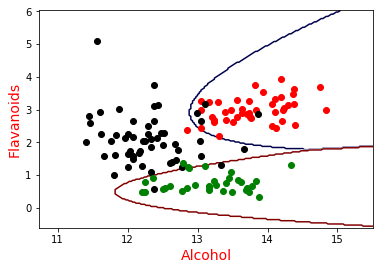

In [32]:
show_decision_boundary(0,6)

### <font color="magenta">Fast exercise 2</font>

Can you add interactive sliders to function **show_decision_boundary**?

### <font color="magenta">Fast exercise 3</font>

Produce a plot similar to that of **show_decision_boundary**, but in which just the **test** data is shown.
Look back at your answer to *Fast exercise 1*. Is it corroborated by your plot? Are the errors clearly visible?